In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
def load_and_prepare_data():
    """
    Load and prepare the Elliptic dataset with proper column names and typing.
    Using relative paths since files are in the same directory.
    """
    # Relative paths - files in same directory as notebook
    features_path = 'elliptic_txs_features.csv'
    classes_path = 'elliptic_txs_classes.csv'
    edges_path = 'elliptic_txs_edgelist.csv'
    
    # Load features (no header in this file)
    df_features = pd.read_csv(features_path, header=None)
    
    # Define column names based on paper description
    col_names = ['tx_id', 'time_step']
    col_names += [f'local_{i}' for i in range(1, 94)]        # Local transaction features start at local_1
    col_names += [f'aggregated_{i}' for i in range(1, 73)]   # Aggregated features start at aggregated_1

    df_features.columns = col_names
    
    # FIX: Convert tx_id to integer first (it's being read as float)
    df_features['tx_id'] = df_features['tx_id'].astype(int)
    
    # Load classes and merge
    df_classes = pd.read_csv(classes_path)
    df_features = df_features.merge(
        df_classes.rename(columns={'txId': 'tx_id'}),
        on='tx_id',
        how='left',
        validate='one_to_one'  # Ensure no duplicate transactions
    )
    
    # Convert class to categorical with meaningful names
    df_features['label'] = df_features['class'].map({
        '1': 'illicit',
        '2': 'licit'
    }).fillna('unknown')
    
    # Add binary target for ML models
    df_features['is_illicit'] = (df_features['class'] == '1').astype(int)
    df_features['is_licit'] = (df_features['class'] == '2').astype(int)
    df_features['is_labeled'] = df_features['class'].isin(['1', '2'])
    
    # Set appropriate dtypes
    df_features['time_step'] = df_features['time_step'].astype(int)
    
    # Load edges for graph construction
    df_edges = pd.read_csv(edges_path)
    
    # IMPORTANT: Ensure edges tx_ids are also integers
    df_edges['txId1'] = df_edges['txId1'].astype(int)
    df_edges['txId2'] = df_edges['txId2'].astype(int)
    
    return df_features, df_edges

In [4]:
# Call the function to actually load the data
df_features, df_edges = load_and_prepare_data()

In [5]:
df_features.head()

,tx_id,time_step,local_1,local_2,local_3,local_4,local_5,local_6,local_7,local_8,...,aggregated_68,aggregated_69,aggregated_70,aggregated_71,aggregated_72,class,label,is_illicit,is_licit,is_labeled
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown,unknown,0,0,False
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown,unknown,0,0,False
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,unknown,unknown,0,0,False
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2,licit,0,1,True
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.277775,0.326394,1.293750,0.178136,0.179117,unknown,unknown,0,0,False


In [6]:
key_columns = ['tx_id', 'time_step', 'local_1', 'local_93', 'aggregated_1', 'aggregated_72', 'class', 'is_labeled']
df_features[key_columns].head()

,tx_id,time_step,local_1,local_93,aggregated_1,aggregated_72,class,is_labeled
0,230425980,1,-0.171469,1.135279,-0.169160,-0.119792,unknown,False
1,5530458,1,-0.171484,-1.084845,-0.170113,-0.119792,unknown,False
2,232022460,1,-0.172107,-1.084845,-0.170528,-0.119792,unknown,False
3,232438397,1,0.163054,0.025217,-0.171098,-0.119792,2,True
4,230460314,1,1.011523,-0.563089,-0.162974,0.179117,unknown,False


In [7]:
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [8]:
print(df_features.columns.tolist())

['tx_id', 'time_step', 'local_1', 'local_2', 'local_3', 'local_4', 'local_5', 'local_6', 'local_7', 'local_8', 'local_9', 'local_10', 'local_11', 'local_12', 'local_13', 'local_14', 'local_15', 'local_16', 'local_17', 'local_18', 'local_19', 'local_20', 'local_21', 'local_22', 'local_23', 'local_24', 'local_25', 'local_26', 'local_27', 'local_28', 'local_29', 'local_30', 'local_31', 'local_32', 'local_33', 'local_34', 'local_35', 'local_36', 'local_37', 'local_38', 'local_39', 'local_40', 'local_41', 'local_42', 'local_43', 'local_44', 'local_45', 'local_46', 'local_47', 'local_48', 'local_49', 'local_50', 'local_51', 'local_52', 'local_53', 'local_54', 'local_55', 'local_56', 'local_57', 'local_58', 'local_59', 'local_60', 'local_61', 'local_62', 'local_63', 'local_64', 'local_65', 'local_66', 'local_67', 'local_68', 'local_69', 'local_70', 'local_71', 'local_72', 'local_73', 'local_74', 'local_75', 'local_76', 'local_77', 'local_78', 'local_79', 'local_80', 'local_81', 'local_82', 'l

In [9]:
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [10]:
df_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234355 entries, 0 to 234354
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   txId1   234355 non-null  int64
 1   txId2   234355 non-null  int64
dtypes: int64(2)
memory usage: 3.6 MB


In [11]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Columns: 172 entries, tx_id to is_labeled
dtypes: bool(1), float64(165), int64(4), object(2)
memory usage: 266.0+ MB


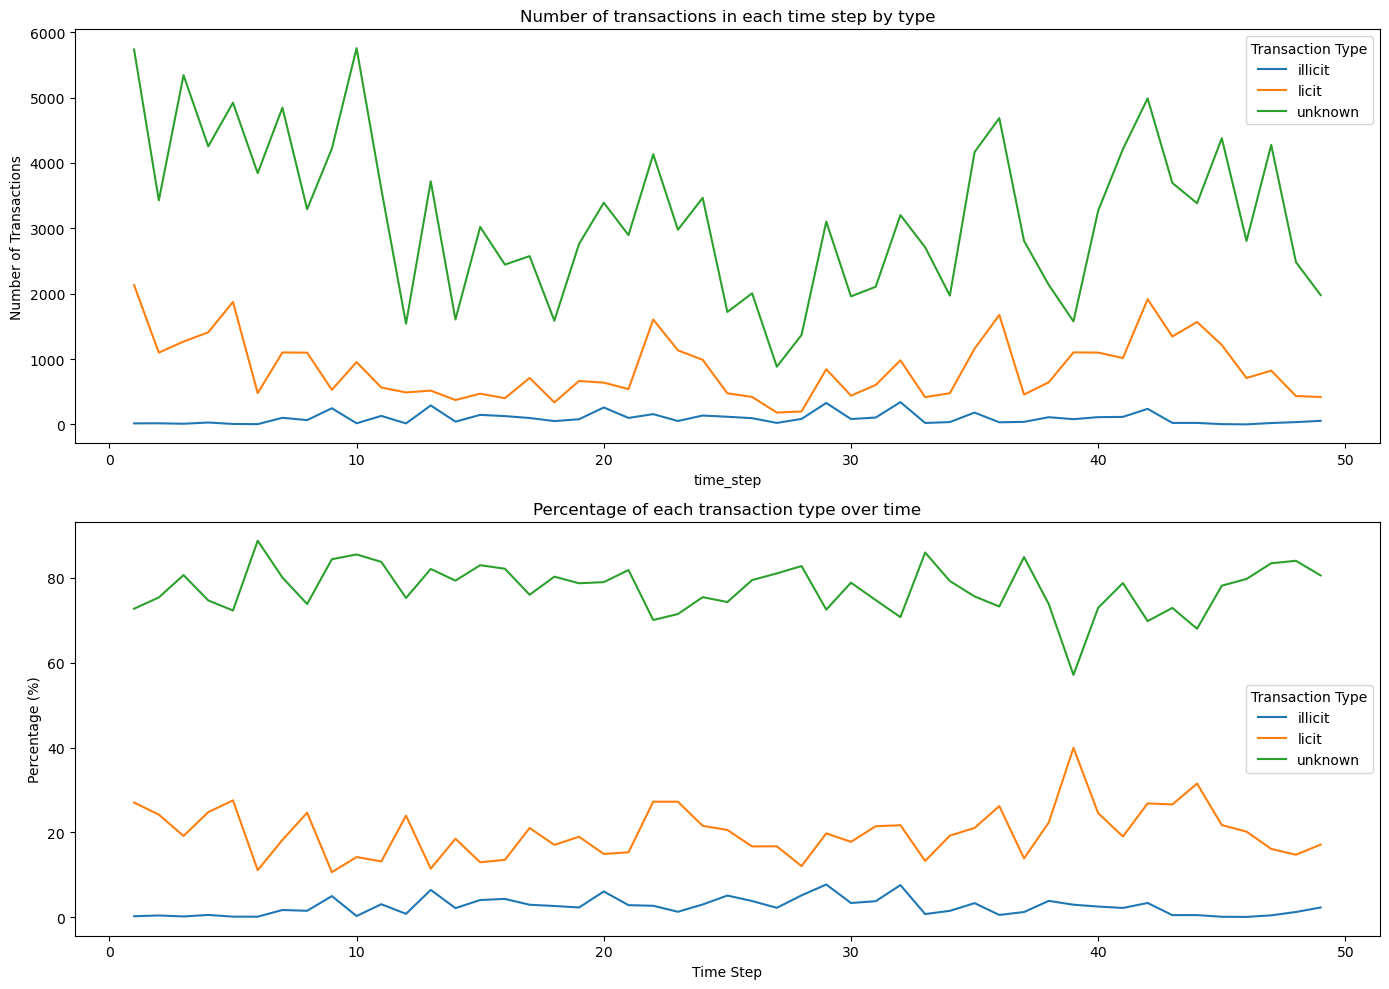

In [12]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top: Absolute counts
grouped = df_features.groupby(['time_step', 'label'])['tx_id'].count().reset_index().rename(columns={'tx_id': 'count'})
sns.lineplot(x='time_step', y='count', hue='label', data=grouped, ax=axes[0])
axes[0].set_title('Number of transactions in each time step by type')
axes[0].set_ylabel('Number of Transactions')
axes[0].legend(title='Transaction Type')

# Bottom: Proportions (more informative for class balance)
pivot = grouped.pivot(index='time_step', columns='label', values='count').fillna(0)
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
pivot_pct.plot(ax=axes[1], kind='line')
axes[1].set_title('Percentage of each transaction type over time')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xlabel('Time Step')
axes[1].legend(title='Transaction Type')

plt.tight_layout()
plt.show()

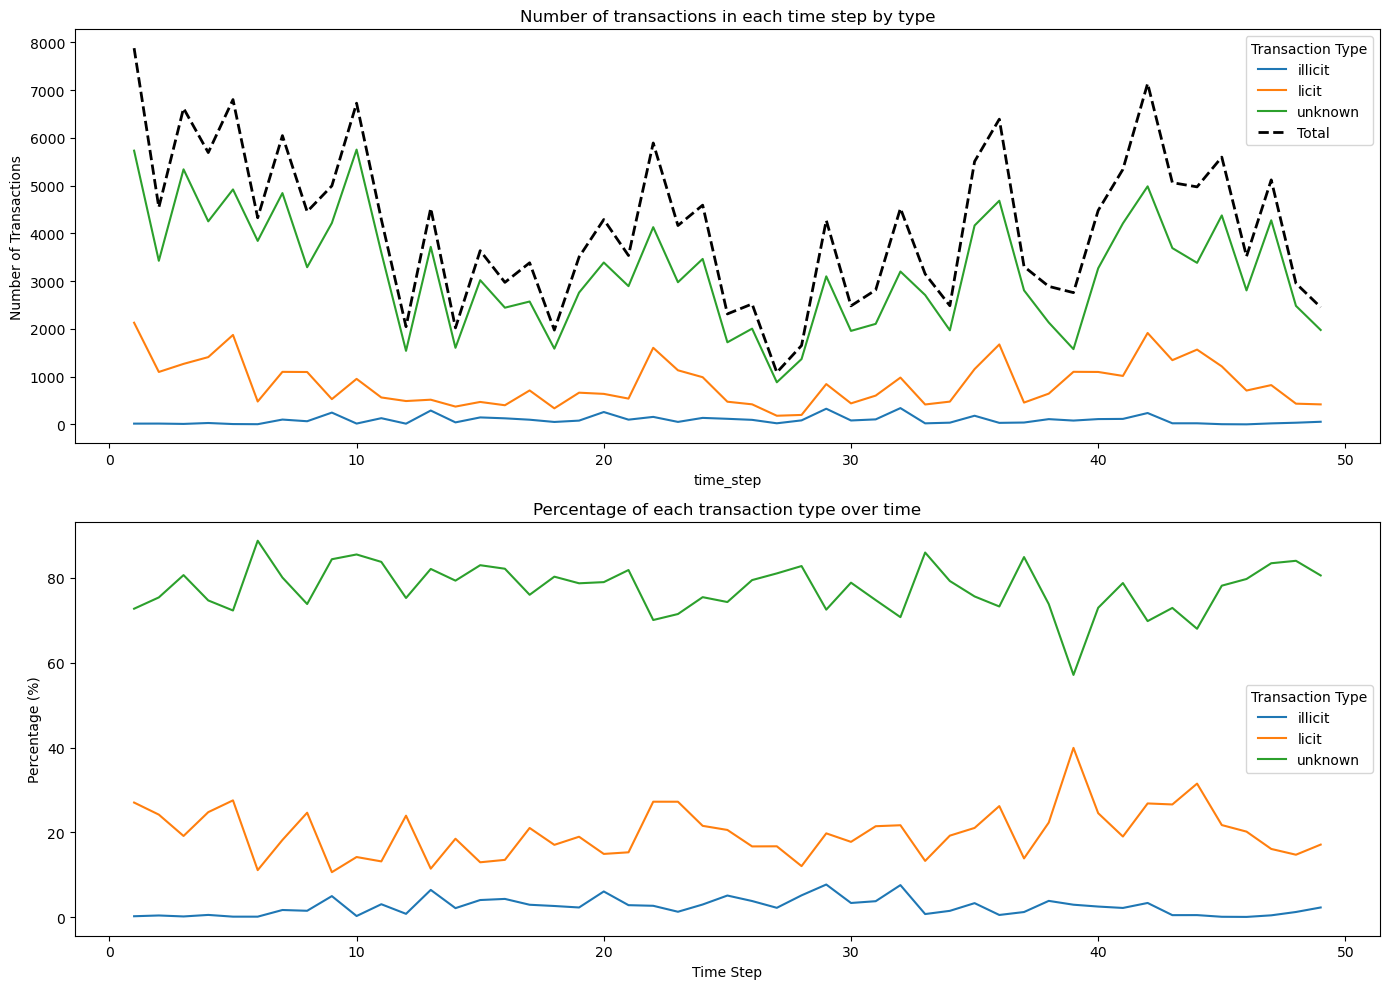

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Figure & axes
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# =========================
# Top: Absolute counts
# =========================
# Count per time_step & label
grouped = (
    df_features
    .groupby(['time_step', 'label'])['tx_id']
    .count()
    .reset_index()
    .rename(columns={'tx_id': 'count'})
)

# Total per time_step (sum across labels)
totals = (
    grouped.groupby('time_step', as_index=False)['count']
    .sum()
    .rename(columns={'count': 'total_count'})
)

# Plot class-wise counts
sns.lineplot(
    data=grouped,
    x='time_step', y='count', hue='label',
    ax=axes[0]
)

# Plot total counts (as a distinct dashed black line)
axes[0].plot(
    totals['time_step'], totals['total_count'],
    linestyle='--', linewidth=2, color='black', label='Total'
)

axes[0].set_title('Number of transactions in each time step by type')
axes[0].set_ylabel('Number of Transactions')

# Rebuild legend to include the 'Total' line
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles, labels=labels, title='Transaction Type')

# =========================
# Bottom: Percentages
# =========================
# Pivot to wide, compute row-wise percentages
pivot = grouped.pivot(index='time_step', columns='label', values='count').fillna(0)
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

# Long form for seaborn
pct_long = (
    pivot_pct
    .reset_index()
    .melt(id_vars='time_step', var_name='label', value_name='percentage')
)

# Plot class-wise percentages (no total line here)
sns.lineplot(
    data=pct_long,
    x='time_step', y='percentage', hue='label',
    ax=axes[1]
)

axes[1].set_title('Percentage of each transaction type over time')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xlabel('Time Step')
axes[1].legend(title='Transaction Type')

plt.tight_layout()
plt.show()


## Transaction Distribution Over Time

**Top Plot - Volume Trends:**
- The dataset spans 49 time steps (approximately 2 years with bi-weekly intervals)
- Most transactions remain **unlabeled** (green line, 2000-6000 per time step)
- **Licit** transactions (orange, ~500-2000 per time step) show moderate activity
- **Illicit** transactions (blue, <500 per time step) are consistently rare
- Notable volume spikes occur around time steps 1-2, 10, and 42

**Bottom Plot - Class Balance:**
- **Unknown transactions dominate** at 70-85% throughout the entire period
- **Licit transactions** represent 15-25% of all transactions
- **Illicit transactions** remain under 5%, showing the significant class imbalance
- The proportions stay relatively stable despite volume fluctuations
- Time step 43 shows an anomaly with increased licit percentage (possible dark market shutdown event mentioned in the paper)

**Key Insight:** The dataset presents two main challenges - (1) severe class imbalance with illicit transactions being rare, and (2) the majority of data being unlabeled, suggesting potential for semi-supervised learning approaches.

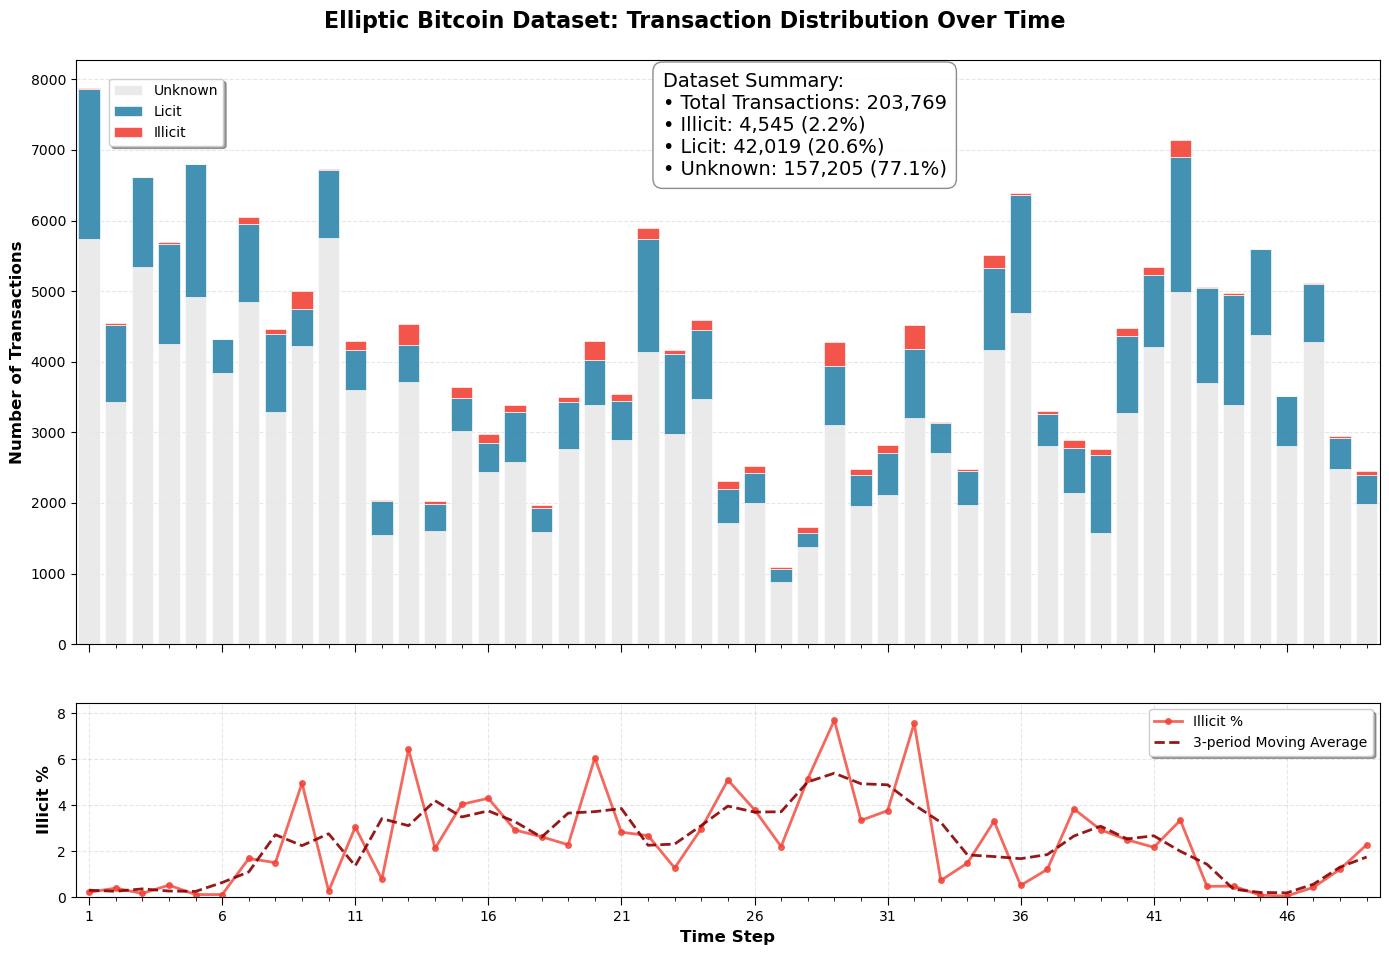


ELLIPTIC DATASET - TIME STEP ANALYSIS

Key Time Steps:
           Unknown  Licit  Illicit  Total  Illicit %
time_step                                           
1             5733   2130       17   7880       0.22
10            5755    954       18   6727       0.27
20            3391    640      260   4291       6.06
30            1959    441       83   2483       3.34
34            1971    478       37   2486       1.49
35            4166   1159      182   5507       3.30
40            3270   1099      112   4481       2.50
49            1978    420       56   2454       2.28

Overall Statistics:
• Training period (1-34): 136,265 transactions
• Test period (35-49): 67,504 transactions
• Peak illicit %: 7.70% (Time Step 29)
• Average illicit %: 2.45%


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for academic presentation
plt.style.use('default')
sns.set_palette("colorblind")

# --------------------------
# 1) Prepare labels robustly
# --------------------------
df = df_features.copy()

# Accept either 'label' as text or 'class' as {1,2,3}
if 'label' in df.columns:
    label_series = df['label'].map({
        'unknown':'Unknown', 'illicit':'Illicit', 'licit':'Licit',
        1:'Illicit', 2:'Licit', 3:'Unknown'   # just in case
    })
elif 'class' in df.columns:
    label_series = df['class'].map({
        '1':'Illicit','2':'Licit','3':'Unknown', 
        1:'Illicit',2:'Licit',3:'Unknown'
    })
else:
    raise ValueError("Expected a 'label' or 'class' column.")

df['label_clean'] = label_series.fillna('Unknown')

# --------------------------
# 2) Aggregate per time step
# --------------------------
counts = (
    df.groupby(['time_step','label_clean'])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=['Unknown','Licit','Illicit'], fill_value=0)
      .sort_index()
)

counts['total'] = counts.sum(axis=1)
counts['illicit_pct'] = 100 * counts['Illicit'] / counts['total'].replace(0, np.nan)
counts['illicit_pct_ma3'] = counts['illicit_pct'].rolling(3, center=True, min_periods=1).mean()

# --------------------------
# 3) Create improved plot
# --------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[3, 1])

# Define professional color palette
colors = {
    'Unknown': '#E8E8E8',    # Light gray
    'Licit': '#2E86AB',      # Professional blue
    'Illicit': '#F24236'     # Alert red
}

x = counts.index.values

# Main stacked bar plot
bottom_licit = counts['Unknown'].values
bottom_illicit = (counts['Unknown'] + counts['Licit']).values

ax1.bar(x, counts['Unknown'].values, width=0.8, 
        color=colors['Unknown'], label='Unknown', alpha=0.9, edgecolor='white', linewidth=0.5)
ax1.bar(x, counts['Licit'].values, width=0.8, bottom=bottom_licit,
        color=colors['Licit'], label='Licit', alpha=0.9, edgecolor='white', linewidth=0.5)
ax1.bar(x, counts['Illicit'].values, width=0.8, bottom=bottom_illicit,
        color=colors['Illicit'], label='Illicit', alpha=0.9, edgecolor='white', linewidth=0.5)

# Styling for main plot
ax1.set_ylabel('Number of Transactions', fontsize=12, fontweight='bold')
ax1.set_xlim(x.min()-0.5, x.max()+0.5)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# Legend for main plot
ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, 
           bbox_to_anchor=(0.02, 0.98))

# Set x-axis ticks
major_ticks = np.arange(1, x.max()+1, 5)
minor_ticks = np.arange(1, x.max()+1, 1)
ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)
ax1.tick_params(axis='x', which='minor', length=3)
ax1.tick_params(axis='x', which='major', length=6)

# Remove x-axis labels from top plot
ax1.set_xticklabels([])

# --------------------------
# 4) Illicit percentage subplot
# --------------------------
ax2.plot(x, counts['illicit_pct'].values, marker='o', markersize=4, 
         linewidth=2, color=colors['Illicit'], label='Illicit %', alpha=0.8)
ax2.plot(x, counts['illicit_pct_ma3'].values, linestyle='--', 
         linewidth=2, color='darkred', label='3-period Moving Average', alpha=0.9)

# Styling for percentage plot
ax2.set_xlabel('Time Step', fontsize=12, fontweight='bold')
ax2.set_ylabel('Illicit %', fontsize=12, fontweight='bold')
ax2.set_xlim(x.min()-0.5, x.max()+0.5)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

# Set reasonable y-limits for percentage
max_pct = max(5, np.nanmax(counts['illicit_pct'])*1.1)
ax2.set_ylim(0, max_pct)

# Set x-axis ticks for bottom plot
ax2.set_xticks(major_ticks)
ax2.set_xticks(minor_ticks, minor=True)
ax2.tick_params(axis='x', which='minor', length=3)
ax2.tick_params(axis='x', which='major', length=6)

# Legend for percentage plot
ax2.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)

# --------------------------
# 5) Overall styling
# --------------------------
fig.suptitle('Elliptic Bitcoin Dataset: Transaction Distribution Over Time', 
             fontsize=16, fontweight='bold', y=0.95)

fig.patch.set_facecolor('white')

plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.15)

# --------------------------
# 6) Add summary statistics box
# --------------------------
total_transactions = counts['total'].sum()
total_illicit = counts['Illicit'].sum()
total_licit = counts['Licit'].sum() 
total_unknown = counts['Unknown'].sum()
overall_illicit_pct = (total_illicit / total_transactions) * 100

stats_text = f"""Dataset Summary:
• Total Transactions: {total_transactions:,}
• Illicit: {total_illicit:,} ({overall_illicit_pct:.1f}%)
• Licit: {total_licit:,} ({(total_licit/total_transactions)*100:.1f}%)
• Unknown: {total_unknown:,} ({(total_unknown/total_transactions)*100:.1f}%)"""

ax1.text(0.45, 0.98, stats_text, transform=ax1.transAxes, fontsize=14,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
         facecolor='white', alpha=0.9, edgecolor='gray'))

plt.show()

# --------------------------
# 7) Export summary table
# --------------------------
print("\n" + "="*60)
print("ELLIPTIC DATASET - TIME STEP ANALYSIS")
print("="*60)

summary_table = counts[['Unknown','Licit','Illicit','total','illicit_pct']].round(2)
summary_table.columns = ['Unknown', 'Licit', 'Illicit', 'Total', 'Illicit %']

# Display key time steps
key_periods = [1, 10, 20, 30, 34, 35, 40, 49]
print("\nKey Time Steps:")
print(summary_table.loc[summary_table.index.intersection(key_periods)])

print(f"\nOverall Statistics:")
print(f"• Training period (1-34): {summary_table.loc[1:34, 'Total'].sum():,} transactions")
print(f"• Test period (35-49): {summary_table.loc[35:49, 'Total'].sum():,} transactions") 
print(f"• Peak illicit %: {summary_table['Illicit %'].max():.2f}% (Time Step {summary_table['Illicit %'].idxmax()})")
print(f"• Average illicit %: {summary_table['Illicit %'].mean():.2f}%")

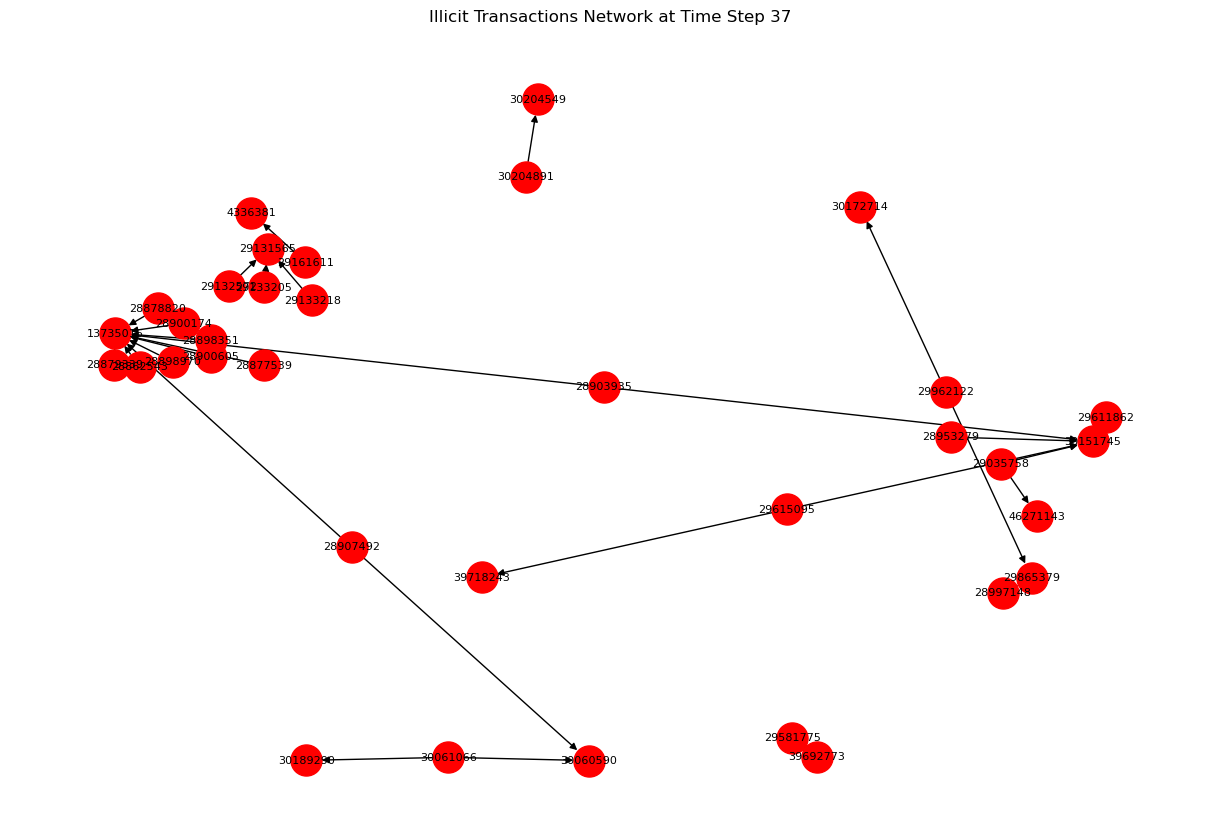

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Filter for illicit transactions at time step 37
bad_ids = df_features.loc[
    (df_features['time_step'] == 37) & 
    (df_features['class'] == '1'), 
    'tx_id'
]

# Get edges involving these illicit transactions
short_edges = df_edges.loc[df_edges['txId1'].isin(bad_ids)]

# Create directed graph
graph = nx.from_pandas_edgelist(
    short_edges, 
    source='txId1', 
    target='txId2',
    create_using=nx.DiGraph()
)

# Visualize
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_color='red', 
        node_size=500, font_size=8, arrows=True)
plt.title('Illicit Transactions Network at Time Step 37')
plt.show()

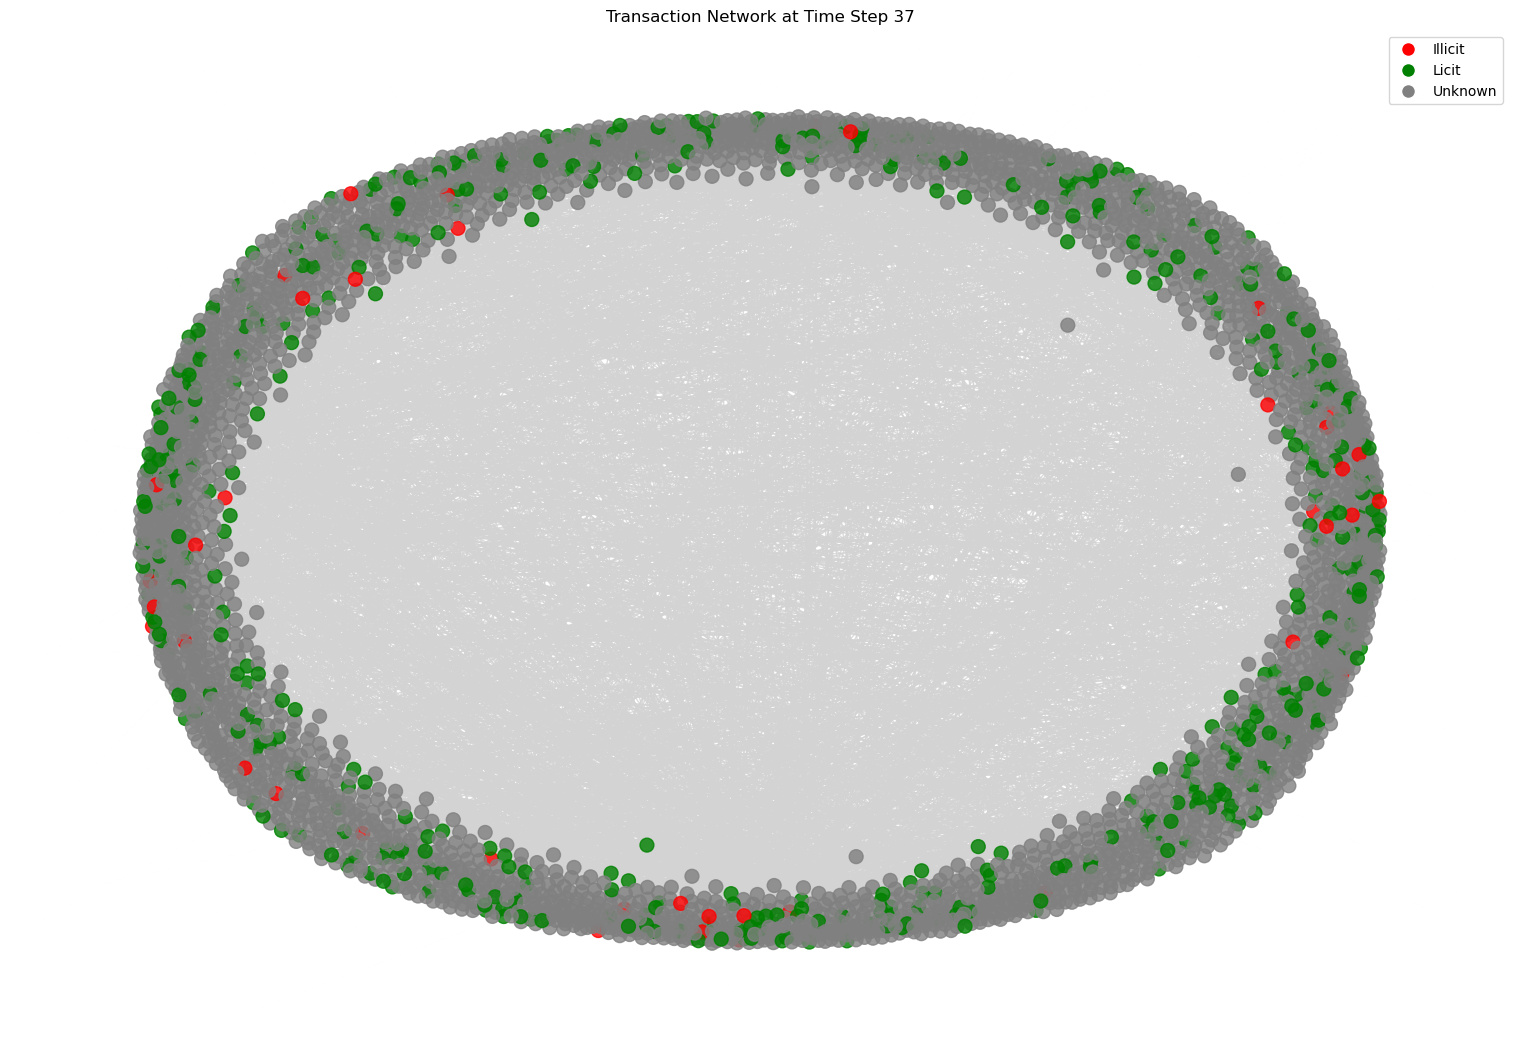

Network Statistics for Time Step 37:
Total nodes: 3306
Total edges: 3849
Illicit nodes: 40
Licit nodes: 458
Unknown nodes: 2808


In [16]:
# More sophisticated visualization showing transaction types
def visualize_transaction_network(time_step=37, show_labels=False):
    """
    Visualize transaction network with different colors for different types
    """
    # Get all transactions at this time step
    ts_data = df_features[df_features['time_step'] == time_step]
    
    # Get edges for this time step
    ts_ids = set(ts_data['tx_id'])
    ts_edges = df_edges[
        df_edges['txId1'].isin(ts_ids) & 
        df_edges['txId2'].isin(ts_ids)
    ]
    
    # Create graph
    G = nx.from_pandas_edgelist(
        ts_edges,
        source='txId1',
        target='txId2',
        create_using=nx.DiGraph()
    )
    
    # Create color map based on transaction class
    color_map = []
    for node in G.nodes():
        node_class = ts_data[ts_data['tx_id'] == node]['class'].values
        if len(node_class) > 0:
            if node_class[0] == '1':
                color_map.append('red')      # Illicit
            elif node_class[0] == '2':
                color_map.append('green')    # Licit
            else:
                color_map.append('gray')     # Unknown
        else:
            color_map.append('gray')
    
    # Plot
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=3, iterations=50)
    
    nx.draw(G, pos,
            node_color=color_map,
            with_labels=show_labels,
            node_size=100,
            font_size=6,
            arrows=True,
            arrowsize=10,
            edge_color='lightgray',
            alpha=0.8)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Illicit'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='Licit'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Unknown')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title(f'Transaction Network at Time Step {time_step}')
    plt.show()
    
    # Print statistics
    illicit_nodes = [n for n, c in zip(G.nodes(), color_map) if c == 'red']
    licit_nodes = [n for n, c in zip(G.nodes(), color_map) if c == 'green']
    
    print(f"Network Statistics for Time Step {time_step}:")
    print(f"Total nodes: {len(G.nodes())}")
    print(f"Total edges: {len(G.edges())}")
    print(f"Illicit nodes: {len(illicit_nodes)}")
    print(f"Licit nodes: {len(licit_nodes)}")
    print(f"Unknown nodes: {len(G.nodes()) - len(illicit_nodes) - len(licit_nodes)}")
    
    return G

# Use it
G = visualize_transaction_network(time_step=37)

In [17]:
# Calculate important graph metrics
def analyze_graph_metrics(G):
    """Analyze structural properties of the transaction graph"""
    
    # Degree centrality - which nodes are most connected
    degree_cent = nx.degree_centrality(G)
    top_nodes = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print("Top 5 nodes by degree centrality:")
    for node, cent in top_nodes:
        node_class = df_features[df_features['tx_id'] == node]['label'].values
        label = node_class[0] if len(node_class) > 0 else 'not in features'
        print(f"  Node {node}: {cent:.3f} ({label})")
    
    # Connected components
    if isinstance(G, nx.DiGraph):
        components = list(nx.weakly_connected_components(G))
    else:
        components = list(nx.connected_components(G))
    
    print(f"\nNumber of connected components: {len(components)}")
    print(f"Largest component size: {len(max(components, key=len))}")
    
    # Clustering coefficient (for undirected)
    if not isinstance(G, nx.DiGraph):
        avg_clustering = nx.average_clustering(G)
        print(f"Average clustering coefficient: {avg_clustering:.3f}")

# Analyze your graph
analyze_graph_metrics(graph)

Top 5 nodes by degree centrality:
  Node 13735016: 0.294 (illicit)
  Node 30151745: 0.147 (licit)
  Node 29131565: 0.088 (licit)
  Node 29035758: 0.059 (illicit)
  Node 28907492: 0.059 (illicit)

Number of connected components: 6
Largest component size: 21


Subgraph: 241 nodes, 295 edges


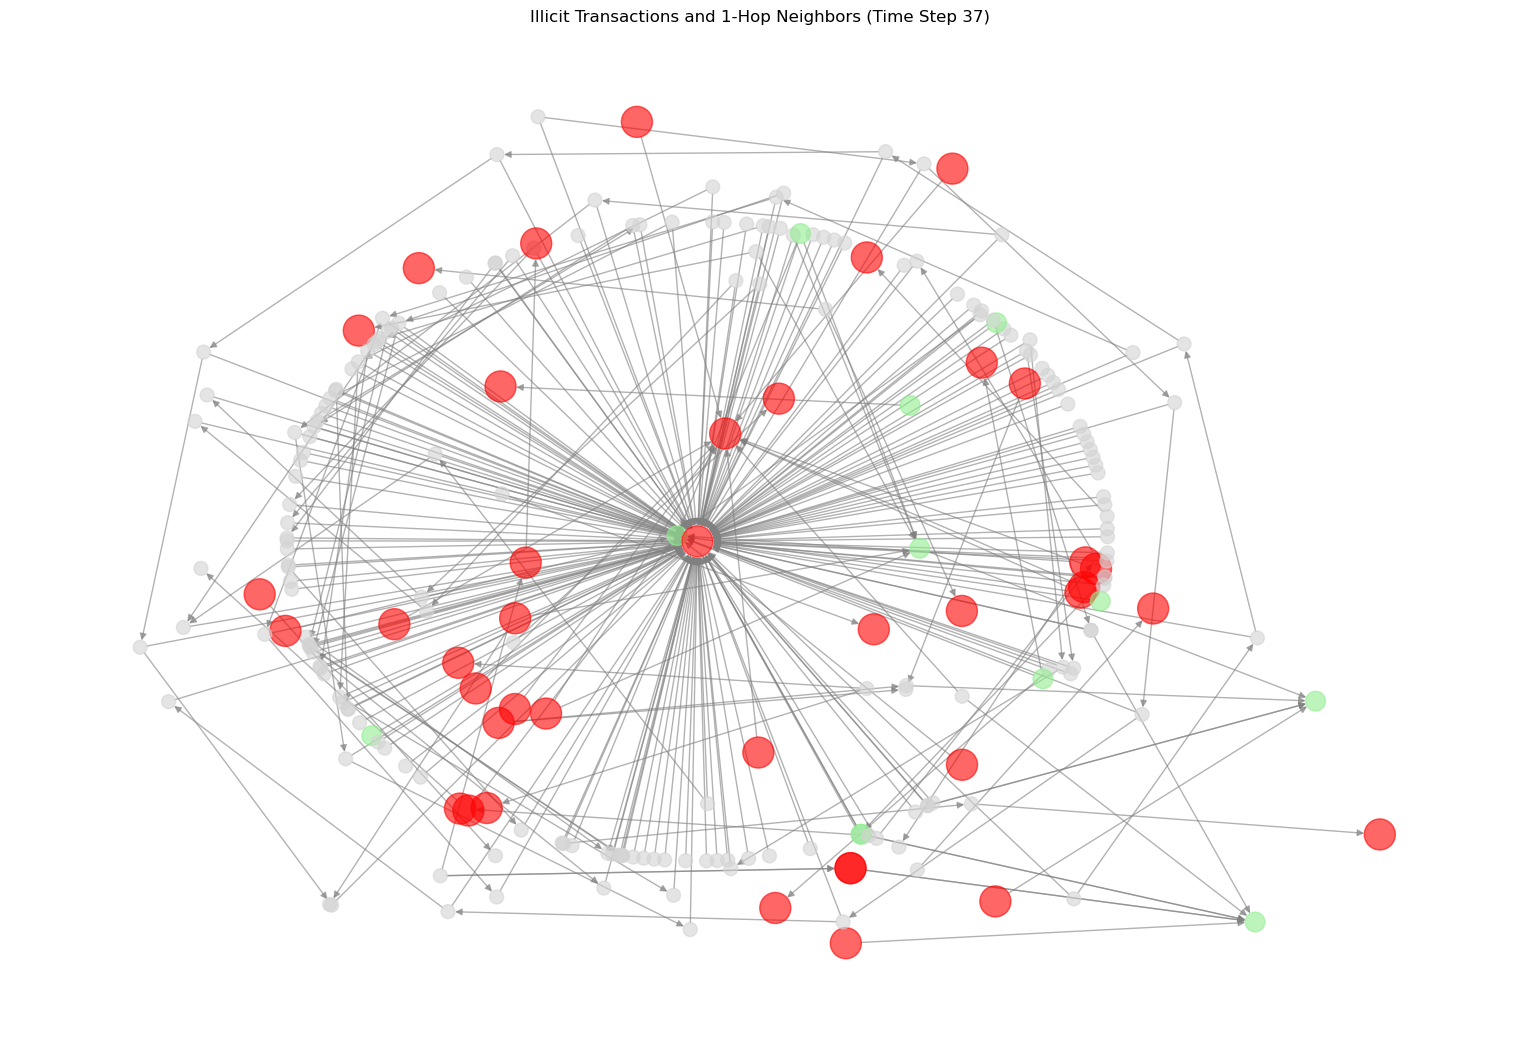

In [18]:
# 1. Focus on illicit nodes and their immediate neighbors only
def visualize_illicit_neighborhood(time_step=37, hops=1):
    """Show illicit nodes and their N-hop neighbors"""
    
    # Get illicit transaction IDs
    illicit_ids = df_features.loc[
        (df_features['time_step'] == time_step) & 
        (df_features['class'] == '1'), 
        'tx_id'
    ].values
    
    # Build full graph for this timestep
    ts_ids = df_features[df_features['time_step'] == time_step]['tx_id']
    ts_edges = df_edges[
        df_edges['txId1'].isin(ts_ids) & 
        df_edges['txId2'].isin(ts_ids)
    ]
    
    G_full = nx.from_pandas_edgelist(ts_edges, 'txId1', 'txId2', create_using=nx.DiGraph())
    
    # Get N-hop neighbors
    nodes_to_include = set(illicit_ids)
    for _ in range(hops):
        for node in list(nodes_to_include):
            if node in G_full:
                nodes_to_include.update(G_full.predecessors(node))
                nodes_to_include.update(G_full.successors(node))
    
    # Create subgraph
    G = G_full.subgraph(nodes_to_include)
    
    # Color nodes
    color_map = []
    size_map = []
    for node in G.nodes():
        node_data = df_features[df_features['tx_id'] == node]
        if len(node_data) > 0:
            if node_data['class'].values[0] == '1':
                color_map.append('red')
                size_map.append(500)  # Larger for illicit
            elif node_data['class'].values[0] == '2':
                color_map.append('lightgreen')
                size_map.append(200)
            else:
                color_map.append('lightgray')
                size_map.append(100)
    
    plt.figure(figsize=(15, 10))
    pos = nx.kamada_kawai_layout(G)  # Better for smaller graphs
    nx.draw(G, pos, node_color=color_map, node_size=size_map,
            with_labels=False, arrows=True, edge_color='gray', alpha=0.6)
    
    plt.title(f'Illicit Transactions and {hops}-Hop Neighbors (Time Step {time_step})')
    return G

G_focused = visualize_illicit_neighborhood(time_step=37, hops=1)
print(f"Subgraph: {len(G_focused.nodes())} nodes, {len(G_focused.edges())} edges")